<a href="https://colab.research.google.com/github/trashpanda900/Data-Science/blob/main/Copy_of_Unit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "preliz[full,notebook]"


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

import preliz as pz

What positions will have the most amount of Turnovers in a game? For context, a turnover in basketball is when a player loses the ball without scoring, either because the ball goes out or the ball gets stolen. More turnovers is typically viewed as poor performance, but what positions will have the most turnovers? I think it will be the point gaurd since they have the ball the most.

In [42]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/trashpanda900/Data-Science/refs/heads/main/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
bb_data = pd.read_csv(url_cs,dtype={'Pos':'category'})
bb_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
5,Grayson Allen,SG,28,PHO,75,74,2513,340,682,0.499,...,48,247,295,227,69,45,95,157,1014,allengr01


In [43]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = bb_data.Pos.cat.codes.values

#an array of the four strings that represent position
# Ensure pos_codes reflects only the categories present in bb_data.Pos
pos_codes = bb_data.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

In [29]:

with pm.Model(coords=bb_coords) as bb_nh_model:
    #priors
    #dims="aa" means to apply the prior seperately
    μ = pm.HalfNormal('μ', sigma=2,
                  dims="pos")
    σ = pm.HalfNormal('σ', sigma=2,
                      dims="pos")

    y = pm.Normal('y',
                  mu = μ[pos_idx],
                  sigma = σ[pos_idx],
                  observed = bb_data.TOV
                  )
#nh for nonheirarchical
    idata_bb_nh = pm.sample()


Output()

<Axes: ylabel='TOV'>

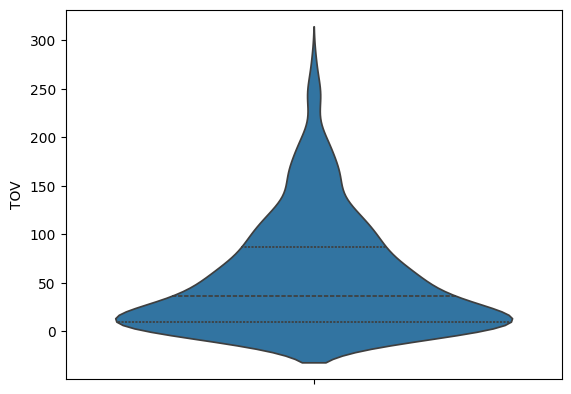

In [27]:
sns.violinplot(bb_data.TOV,inner='quart')

Started with using a Normal prior and Exponential. For the hyper-priors for mu and sigma and I use half normal distribution.

In [7]:


with pm.Model(coords=bb_coords) as bb_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.HalfNormal('μ_mu', sigma = 100)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 100)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "pos")

    #σ = pm.HalfNormal('σ', sigma = 100,
                      #dims = "pos")

    #likelihood
    y = pm.Exponential('y',
                       lam = pm.math.exp(μ[pos_idx]),
                       observed = bb_data.TOV
                 )

    #cs for chemshift, h for heirarchical
    idata_bb_h = pm.sample()

Output()

In [8]:
pm.sample_posterior_predictive( idata_bb_h, model=bb_h_model, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

This looks good but I wanted to try a higher peak, which means switching likelihoods.

(0.0, 500.0)

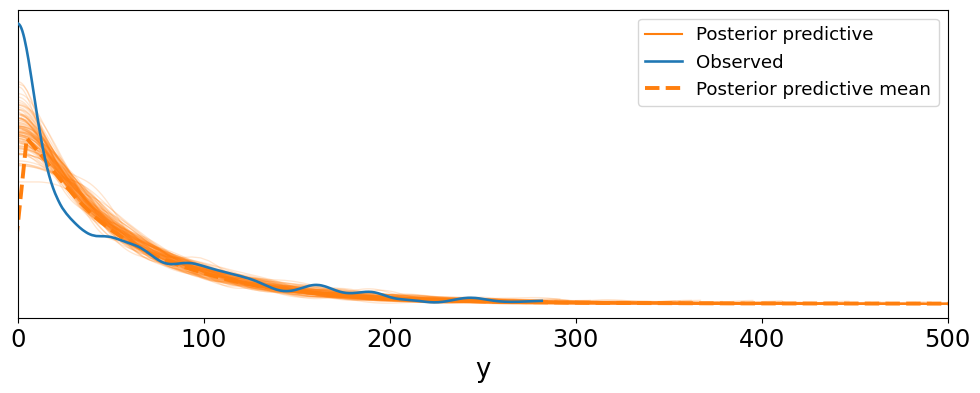

In [24]:
ax = az.plot_ppc(idata_bb_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(0, 500)

For the second model, I used HalfStudent since it is also right skewed. I Experimented with different beta and sigma values, and used HalfCauchy because its all positive.

In [19]:


with pm.Model(coords=bb_coords) as bb_h_model2:


    σ_sd = pm.HalfNormal('σ_sd', sigma=1)


    σ = pm.HalfNormal('σ',
                     sigma=σ_sd,
                     dims="pos")

    nu = pm.HalfCauchy('nu', beta=20)

    observed_data = bb_data.TOV


    y = pm.HalfStudentT('y',
                       nu=nu,
                       sigma=σ[pos_idx],
                       observed=observed_data
                      )

    # sample the model
    idata_bb_h2 = pm.sample()

Output()

In [21]:
pm.sample_posterior_predictive( idata_bb_h2, model=bb_h_model2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

This model game me the desired peak I wanted but also has some outliers.

(0.0, 500.0)

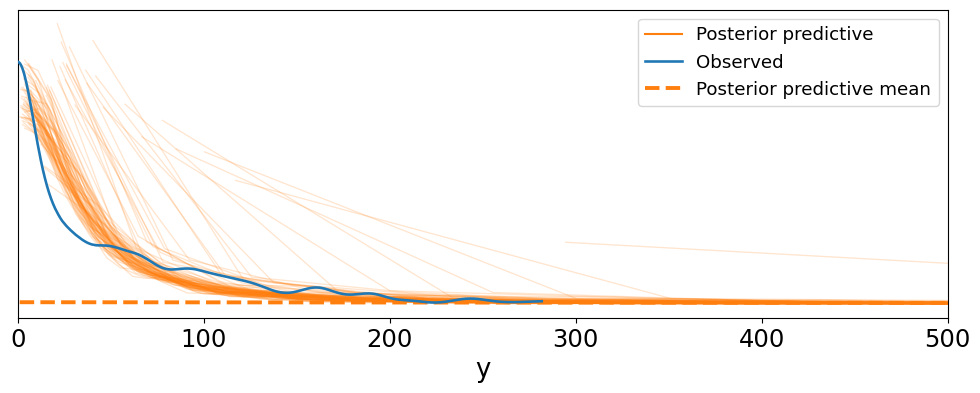

In [25]:
ax = az.plot_ppc(idata_bb_h2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(0, 500)

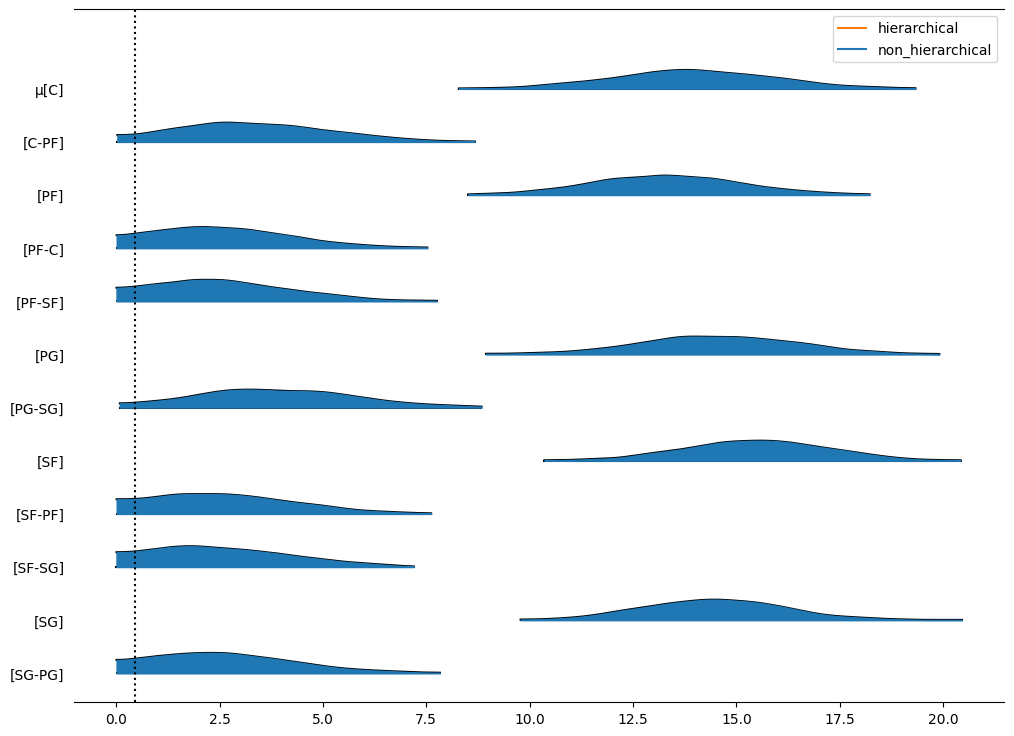

In [38]:
axes = az.plot_forest([idata_bb_nh, idata_bb_h2], kind="ridgeplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 9),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_bb_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

Looking at this ridgeplot, we can see that point gaurds and small forwards will have the most turnovers, witch is mostly consitent with my previous notion. One issue with my model is that it has positions like PG-SG that are players that play multiple, and I couldn't figure out how to figure those players out.